In [234]:
# ridge svd?
#wanna go QR _or_ cholesky or what its called? check monday
#expand a bit to allow looping over noise weights?
# added line to ksajjad
#first mse r2 for low N?
#Most kFold versions look similar. introduce a "method" parameter and consolidate
#bias also increases with model complexity?

#validation set too?
#CENTER DATA?

In [153]:
#import packages
import numpy as np
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
import scipy.linalg as scl
from sklearn.model_selection import KFold
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [154]:
"""
This is an "uglified" version of the FrankeFunction, to minimize use of costly functions like divisions and powers.
It takes as input parameters a meshgrid of coordinates in the x and y direction.
"""
def FrankeFunction(x,y): #still got one division in here
    term1 = 0.75*np.exp(-(0.25*(9*x-2)*(9*x-2)) - 0.25*((9*y-2)*(9*y-2)))
    term2 = 0.75*np.exp(-((9*x+1)*(9*x+1))/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)*(9*x-7)*0.25 - 0.25*((9*y-3)*(9*y-3)))
    term4 = -0.2*np.exp(-(9*x-4)*(9*x-4) - (9*y-7)*(9*y-7))
    return term1 + term2 + term3 + term4

In [155]:
"""
This function creates the Model Matrix, usually dubbed X, for regression analysis.
It takes as input parameters a meshgrid of coordinates in the x and y direction, 
and the polynomial degree P that you wish to fit.

The order of columns is different from the one scikit learn creates, so take care to use the same model-creator when
comparing scikit and this code.

The ordering this function creates is: x^0y^0, x^1y^0, x^2y^0, x^0y^1, x^1y^1, x^0y^2 for a 2nd order polynomial.
"""
def Model(x,y,P): 
    m = len(x)*len(y) # number of equations
    t = sum(range(P+2)) # number of terms in polynomial
    X = np.zeros((m,t)) # Model matrix
    a = np.matrix.flatten(x)
    b = np.matrix.flatten(y)
    c = 0 #counter
    for i in range(P+1):
        for j in range(P+1-i):
            X[:,c] = a**j*b**i
            c +=1
    return X

In [156]:
def ols_svd(X: np.ndarray, z: np.ndarray,_lambda) -> np.ndarray:
    u, s, v = scl.svd(X)
    pin = scl.diagsvd(1./s,len(v),len(u))
#     return v.T @ scl.pinv(scl.diagsvd(s, u.shape[0], v.shape[0])) @ u.T @ z
    return v.T @ pin @ u.T @ z
#pinx xt x
# THIS ALGO NEEDS IMPROVEMENT! QR decomp

#same results as skl up to and including mpd14

In [157]:
def ols_inv(X: np.ndarray, z: np.ndarray) -> np.ndarray:
    return scl.inv(X.T @ X) @ (X.T @ z)

In [158]:
"""
Just a standard R2 score calculator, taking the measured/real data as the first input, and the values the 
regression model finds as the second input
"""
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

In [159]:
"""
Standard mean squared error calculator, inputs are measured/real data and regression model values.
"""
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

In [160]:
#define variance function
def Var(y_data, y_model,P,X):
    N = len(y_data)
    covar = np.linalg.inv(X.T.dot(X))#sigma2, should be 1 in this case
    vari = np.diagonal(covar)
    return vari

In [161]:
# def Var2(y_data,y_model,n):
#     m = len(y_data)
#     res = y_data-y_model
#     return (1./(m-n-1))*(res.T@res)
# #     return np.mean(y_model**2)-np.mean(yh)

In [162]:
def Bias(y_data, y_model, P, X):
    N = len(y_data) #should probably insert z here
    # also want the expectation values
    #this is where i want to shuffle my data and do 10 kfolds.
    #maybe...
    #can not use each fold and create a mean from them?
    return np.sum((y_data-y_model)*(y_data-y_model))/N

In [163]:
# def Bias2(y_data,y_model):
#     n = len(y_data)
#     return np.sum((y_data-(np.mean(y_model)))**2)/n

In [164]:
#Create random variables/predictors
np.random.seed(1234)
N = 20 #number of points along x and y axes

# sort this for meshgrid
x = np.random.uniform(0,1,N)
y = np.random.uniform(0,1,N)

x = sorted(x)
y = sorted(y)
x, y = np.meshgrid(x,y,sparse=False)

#create datapoints/results
z = FrankeFunction(x, y)

# Create noise
noise_weight = 0.1 #might wanna make a function for this to loop over weights?
Noise = noise_weight*np.random.randn(N,N)

#add noise
z_n = z+Noise

#flatten for use in functions
z_n = np.matrix.flatten(z_n) ##### RAVEL?
z = np.matrix.flatten(z)

#added a 0 Ridge parameter
_lambda = 0.0

In [165]:
MPD =5#maximal polynomial degree

X = Model(x,y,MPD) #create model matrix
print(np.shape(X))

(400, 21)


In [166]:
def NoResampling(X,z_n,_lambda):
#     beta = np.linalg.inv(X.T.dot(X)+_lambda*np.eye(len(X[0][:]))).dot(X.T).dot(z_n)
#     beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(z_n)
#     beta = ols_svd(X,z_n,_lambda)
    beta = ols_inv(X,z_n)
    ztilde = X @ beta
#     print(ztilde)
#     print(z_n)
#     return ztilde
    return MSE(z_n,ztilde), R2(z_n,ztilde)

In [167]:
NoResampling(X,z_n,0)

(0.009934081772912787, 0.8636859826369336)

In [168]:
## find parameters
beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(z_n)
# beta = ols_svd(X,z_n,_lambda)
# beta=ols_inv(X,z_n)
## make prediction
ztilde = X @ beta

In [169]:
######  Makes model matrix, looks different than mine #####
# form: x0y0, x1y0, x0y1, x2y0, x1y1, x0y2
# poly2 = PolynomialFeatures(degree=MPD)
# a = x[:,np.newaxis]
# b = y[:,np.newaxis]
# cc = np.c_[a,b]
# Xskl = poly2.fit_transform(cc) 
##########################################################
# THIS CELL IS CURRENTLY NOT IN USE #

In [170]:
# find parameters
clf = skl.LinearRegression(fit_intercept=False) #False to not center data, i.e. intercept is not 0
clf.fit(X,z_n) 

#make prediction
zpredict = clf.predict(X)

In [171]:
# The mean squared error              
print("Mean squared error (self): %.5f" % MSE(z_n, ztilde))
print("Mean squared error (skl): %.5f" % mean_squared_error(z_n, zpredict))

# Explained variance score: 1 is perfect prediction     
print('R2 score (self): %.5f' %R2(z_n, ztilde))
print('R2 score (skl): %.5f' % r2_score(z_n, zpredict))


Mean squared error (self): 0.00993
Mean squared error (skl): 0.00993
R2 score (self): 0.86369
R2 score (skl): 0.86369


In [172]:
print(Var(z_n, ztilde, MPD,X)) #my variances in betas
print(Var(z_n,zpredict,MPD,X)) #skl variances in betas

[3.60112759e+00 1.68962653e+02 3.85104836e+03 1.99767433e+04
 2.19676147e+04 3.37963857e+03 5.06245587e+02 3.08304299e+03
 9.23665930e+03 9.81043796e+03 1.92921768e+03 9.54247658e+03
 1.81187313e+04 1.05153261e+04 1.88932564e+03 3.90651199e+04
 2.44950728e+04 2.66774665e+03 3.75113917e+04 5.03478679e+03
 5.53673423e+03]
[3.60112759e+00 1.68962653e+02 3.85104836e+03 1.99767433e+04
 2.19676147e+04 3.37963857e+03 5.06245587e+02 3.08304299e+03
 9.23665930e+03 9.81043796e+03 1.92921768e+03 9.54247658e+03
 1.81187313e+04 1.05153261e+04 1.88932564e+03 3.90651199e+04
 2.44950728e+04 2.66774665e+03 3.75113917e+04 5.03478679e+03
 5.53673423e+03]


In [173]:
print(beta) #my betas
print(clf.coef_) #skl betas

[  0.46120129  12.23793297 -61.81639668 103.3688922  -69.42977597
  14.94643658   3.24429948 -17.78265692  74.01006171 -94.381336
  36.30755058 -10.35535351  13.36434547 -13.33707979  16.55056058
   1.24997462 -24.09805794  -6.95787169  18.94208319  17.21716778
 -13.48107648]
[  0.46120129  12.23793298 -61.81639679 103.36889254 -69.4297764
  14.94643676   3.24429948 -17.78265692  74.01006164 -94.38133586
  36.3075505  -10.3553535   13.36434548 -13.33707983  16.5505606
   1.24997458 -24.09805793  -6.95787169  18.94208323  17.21716778
 -13.48107649]


In [174]:
std = 1.96*np.sqrt(abs(Var(z_n, ztilde, MPD,X))) ###ABS??

for i in range(len(std)):
    print(beta[i],std[i])
#these things are huge, something is probably off

0.4612012873817555 3.7194208895114502
12.237932968435507 25.47718444851932
-61.816396680950625 121.63135849083399
103.3688922011032 277.0246508032938
-69.42977597110865 290.50092729172343
14.946436575690132 113.94393144189458
3.2442994783960506 44.09980777086039
-17.782656921130506 108.82930646739804
74.01006170767683 188.3707789995627
-94.3813359986476 194.1334037603483
36.30755058443033 86.08880671046933
-10.3553535126796 191.46377734975067
13.364345468707167 263.8274402705929
-13.337079788951675 200.98675723551938
16.55056057630301 85.19409237570713
1.2499746169669166 387.39200384991227
-24.09805793601847 306.757675571716
-6.9578716931128595 101.23445817126913
18.9420831916323 379.6100136856037
17.217167784428366 139.0742137083996
-13.481076478888596 145.84210028705945


In [175]:
# 95% CI: mu +-1.96*sigma
print(np.shape(X),np.shape(z_n))

(400, 21) (400,)


In [176]:
def ksajjad(X,z,k):
    k = int(np.math.ceil((1./k)*len(X))) ##ADDED this line, show sajjad
    n,m = np.shape(X)
    ind = np.arange(0,n,k)
    for i in ind:
        X_test, z_test = X[i:(i+k),:],z[i:(i+k)]
        if i ==0:
            X_train,z_train = X[i+k:,:],z[i+k:]
        elif i ==(n-k):
            X_train,z_train = X[:i,:],z[:i]
        else:
            X_train = np.vstack([X[:i,:],X[i+k:,:]])
            z_train = np.hstack([z[:i],z[i+k:]])
        yield X_train, X_test, z_train, z_test

In [177]:
XX = np.array([[2,2,2],[3,3,3],[4,4,4],[5,5,5],[6,6,6],[7,7,7],[8,8,8],[9,9,9],[0,0,0]])
zz = np.array([2,3,4,5,6,7,8,9,0])

for X_train, X_test, z_train, z_test in ksajjad(XX,zz,5):
    print(X_train)
    print("--------------------")

[[4 4 4]
 [5 5 5]
 [6 6 6]
 [7 7 7]
 [8 8 8]
 [9 9 9]
 [0 0 0]]
--------------------
[[2 2 2]
 [3 3 3]
 [6 6 6]
 [7 7 7]
 [8 8 8]
 [9 9 9]
 [0 0 0]]
--------------------
[[2 2 2]
 [3 3 3]
 [4 4 4]
 [5 5 5]
 [8 8 8]
 [9 9 9]
 [0 0 0]]
--------------------
[[2 2 2]
 [3 3 3]
 [4 4 4]
 [5 5 5]
 [6 6 6]
 [7 7 7]
 [0 0 0]]
--------------------
[[2 2 2]
 [3 3 3]
 [4 4 4]
 [5 5 5]
 [6 6 6]
 [7 7 7]
 [8 8 8]
 [9 9 9]]
--------------------


# b

In [178]:
k = 10 # number of folds
partition = 0.2 # percentage of data to use for testing

In [179]:
def Shuffler(X,z_n):
#     np.random.seed(1234)
    n = len(X[0,:])
    combi = np.c_[X,z_n] #combine
    np.random.shuffle(combi) #shuffle
    X, z_n = combi[:,:n], combi[:,n] #split
    return X, z_n

In [180]:
def kFold(k,X,z_n):
    #shuffle data before doing the kFold
    X,z_n = Shuffler(X,z_n)

    #initialize values
    z_test_per_fold = []
    z_tilde_per_fold = []
    sMSE = 0. #sum mean squared error
    sR2 = 0. #sum R2 score
    
    for X_train, X_test, z_train, z_test in ksajjad(X,z_n,k):
        # find parameters
        beta = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train)
#         beta = ols_svd(X_train,z_train,0.)

        # make prediction
        z_tilde = X_test @ beta
        
        #store data per fold
        z_test_per_fold.append(z_test)
        z_tilde_per_fold.append(z_tilde)

    #prepare data before returning (sorting needed due to shuffles)
    z_test_per_fold = np.hstack(z_test_per_fold)
    z_tilde_per_fold = np.hstack(z_tilde_per_fold)
    order = np.argsort(z_test_per_fold)
    z_tilde_per_fold = z_tilde_per_fold[order]
    
    return z_tilde_per_fold,beta

In [181]:
def kFoldskl(k,X,z_n):
    #shuffle data before doing the kFold
    X, z_n = Shuffler(X,z_n)

    #initialize values
    z_test_per_fold = []
    z_tilde_per_fold = []
    
    kfold = KFold(k,shuffle=False)   
    for train,test in kfold.split(X,z_n):
        # find parameters
        clf = skl.LinearRegression(fit_intercept=False) #False to not center data, i.e. intercept is not 0
        clf.fit(X[train],z_n[train]) 

        #make prediction
        z_tilde = clf.predict(X[test])

        z_test_per_fold.append(z_n[test])
        z_tilde_per_fold.append(z_tilde)
        
    #prepare data before returning (sorting needed due to shuffles)
    z_test_per_fold = np.hstack(z_test_per_fold)
    z_tilde_per_fold = np.hstack(z_tilde_per_fold)
    order = np.argsort(z_test_per_fold)
    z_tilde_per_fold = z_tilde_per_fold[order]
    
    return z_tilde_per_fold, clf.coef_

In [182]:
z_n_sorted = sorted(z_n)

print(z_n[0],z_n_sorted[0])
print(MSE(kFold(k,X,z_n)[0],z_n_sorted))
print(MSE(kFoldRidge(k,X,z_n,0.),z_n_sorted))
print(MSE(kFoldskl(k,X,z_n)[0],z_n_sorted))
print(z_n[0],z_n_sorted[0])
# kFoldLassoCV(k,X,z_n,[-1,0,1])

0.8314910682022058 -0.14392819049451722
0.011353559401555177
0.011179880571950976
0.012152975784167106
0.8314910682022058 -0.14392819049451722


In [185]:
#Run NN kFolds to create bias/variance plot
#My bias increases again with model complexity
NN=5
mpd = 10
qq = len(z_n)

#sort noisy signal
z_n_sorted = sorted(z_n)

#initialize variables 
NMSE_k = np.zeros(shape=(NN,mpd)) #MSE stored for each run of kFold
model_values = np.zeros(shape=(NN,mpd,qq))
bias2 = np.zeros(mpd)
var = np.zeros(mpd)
bias2_ = np.zeros(shape=(mpd,qq))
var_ = np.zeros(shape=(mpd,qq))

# betas = np.zeros(shape=(NN,mpd))
betas=[]
#Run NN kFolds
for l in range(NN):
    #shuffle here
    for i in range(mpd):
        X = Model(x,y,i+1)
#         model_values[l,i] = kFoldskl(k,X,z_n)[0]
        model_values[l,i] = kFold(k,X,z_n)[0]
        NMSE_k[l,i] = MSE(model_values[l,i],z_n_sorted)
        if l == 0:
            betas.append(kFold(k,X,z_n)[1])
NMSE = np.mean(NMSE_k,axis=0)

#Calculate bias and variance for each polynomial degree
for i in range(mpd):
    for m in range(qq):
        bias2_[i,m] = np.mean(model_values[:,i,m])
        var_[i,m] = np.var(model_values[:,i,m])
    bias2[i]=np.mean((z_n_sorted-bias2_[i])**2)
    var[i] = np.mean(var_[i])

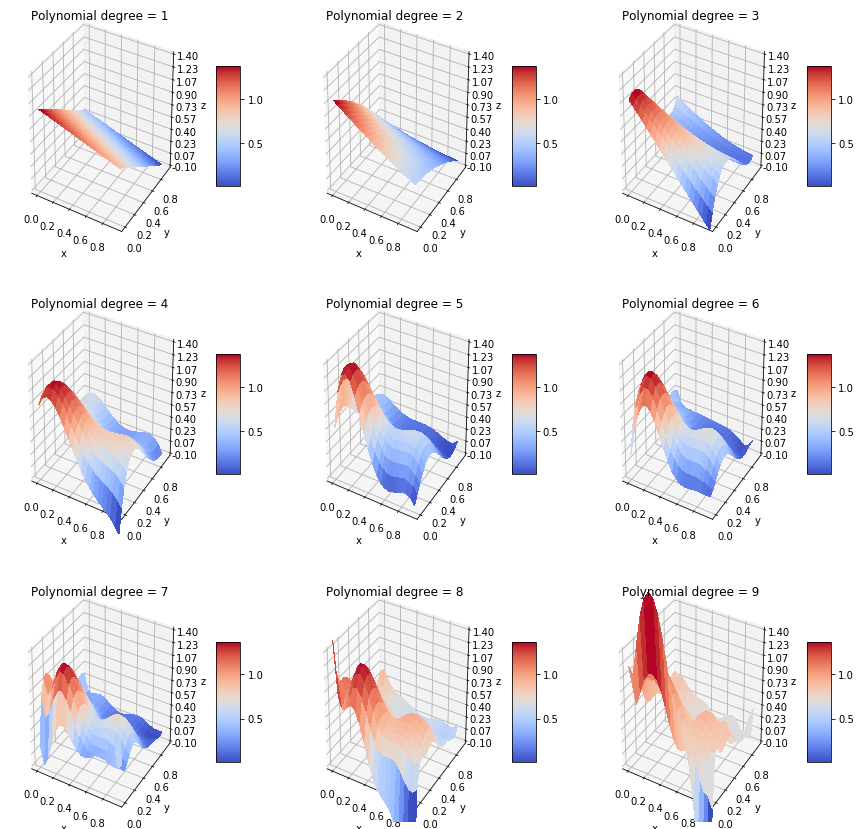

In [233]:
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
xp = np.arange(0,1,0.05)
yp = np.arange(0,1,0.05)
xp,yp = np.meshgrid(xp,yp,sparse=False)
xz,yz = np.meshgrid(xp,yp,sparse=True)
pd = 9

for i in range(pd):
    axs = fig.add_subplot(3,3,i+1,projection='3d')
    Xp = Model(xz,yz,i+1)
    zp = Xp@betas[i]
    zp.shape=(20,20)
    axs.plot_surface(xp,yp,zp,cmap=cm.coolwarm,linewidth=0,antialiased=False)
    axs.set_xlabel('x')
    axs.set_ylabel('y')
    axs.set_zlabel('z')
    axs.set_title('Polynomial degree = {}'.format(i+1))
    axs.set_zlim(-0.10,1.40)
    axs.zaxis.set_major_locator(LinearLocator(10))
    axs.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf,shrink=0.5, aspect=5,pad = 0.1)

plt.show()

In [202]:
# ##FIND MODEL BETAS ONCE, THEN test NN times on those. seems not to work



# #Run NN kFolds to create bias/variance plot
# NN=5
# mpd = 10
# qq = len(z_n)

# #sort noisy signal
# z_n_sorted = sorted(z_n)

# #initialize variables 
# NMSE_k = np.zeros(shape=(NN,mpd)) #MSE stored for each run of kFold
# z_s = np.zeros(shape=(NN,mpd,qq))
# bias2 = np.zeros(mpd)
# var = np.zeros(mpd)
# bias2_ = np.zeros(shape=(mpd,qq))
# var_ = np.zeros(shape=(mpd,qq))
# NMSE = np.zeros(shape=(mpd))
# betass=[]
# for i in range(mpd):
#     X = Model(x,y,i+1)
#     beta = 0
#     for X_train, X_test, z_train, z_test in ksajjad(X,z_n,k):
#         beta += np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train)
#     betass.append(beta/k)
# # mu =[]
# # #Run NN kFolds
# for i in range(mpd):
#     mu=[]
#     my=[]
#     X = Model(x,y,i+1)
# #     for l in range(NN):
# #     #shuffle here        
# #         X = Model(x,y,i+1)
#     X,z_n = Shuffler(X,z_n)
#     for X_train, X_test, z_train, z_test in ksajjad(X,z_n,k):

# #         XX,zz = Shuffler(X_test,z_test)
# #         X = Model(x,y,i+1)
# #         mu.append(XX@betass[i])
#         mu.append(X_test@betass[i])

# #         model_values[l,i] = kFoldskl(k,X,z_n)
# # #         model_values[l,i] = kFold(k,X,z_n)
# #         my.append(MSE(mu,zz))
#         my.append(MSE(mu,z_test))
#     NMSE[i] = np.mean(my)
# # print(my)
# #     NMSE[i] = MSE(np.array([mu]).ravel(),z_n)
# #     print(NMSE[i])
# # NMSE = np.mean(my,axis=0)
# # print(NMSE)
# # NMSE = np.mean(NMSE_k,axis=0)

# #Calculate bias and variance for each polynomial degree
# # for i in range(mpd):
# #     for m in range(qq):
# #         bias2_[i,m] = np.mean(z_s[:,i,m])
# #         var_[i,m] = np.var(z_s[:,i,m])
# #     bias2[i]=np.mean((z_n_sorted-bias2_[i])**2)
# #     var[i] = np.mean(var_[i])

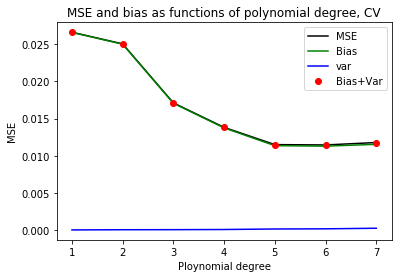

In [241]:
ols_noise = 8
legs = 'MSE','Bias','var','Bias+Var'
plt.figure()
maxi = 7
plt.plot(np.arange(1,maxi+1),NMSE[:maxi],'k')
plt.plot(np.arange(1,maxi+1),bias2[:maxi],'g')
plt.plot(np.arange(1,maxi+1),var[:maxi],'b')
plt.plot(np.arange(1,maxi+1),bias2[:maxi]+var[:maxi],'ro')
plt.xlabel('Ploynomial degree')
plt.ylabel('MSE')
plt.title('MSE and bias as functions of polynomial degree, CV')
plt.legend(legs)
plt.show()

In [237]:
def kFoldRidge(k,X,z_n,_lambda):
    #shuffle data before doing the kFold
    X,z_n = Shuffler(X,z_n)
    n = len(X[0,:])

    #initialize values
    z_test_per_fold = []
    z_tilde_per_fold = []
    sMSE = 0. #sum mean squared error
    sR2 = 0. #sum R2 score
    
    for X_train, X_test, z_train, z_test in ksajjad(X,z_n,k):
        # find parameters
        beta = np.linalg.inv(X_train.T.dot(X_train)+_lambda*np.eye(n)).dot(X_train.T).dot(z_train)

        # make prediction
        z_tilde = X_test @ beta
        
        #store data per fold
        z_test_per_fold.append(z_test)
        z_tilde_per_fold.append(z_tilde)

    #prepare data before returning (sorting needed due to shuffles)
    z_test_per_fold = np.hstack(z_test_per_fold)
    z_tilde_per_fold = np.hstack(z_tilde_per_fold)
    order = np.argsort(z_test_per_fold)
    z_tilde_per_fold = z_tilde_per_fold[order]
    
    return z_tilde_per_fold

In [ ]:
print(z_n[0],z_n_sorted[0])
print(MSE(kFold(k,X,z_n),z_n_sorted))
print(MSE(kFoldRidge(k,X,z_n,0.),z_n_sorted))
print(MSE(kFoldskl(k,X,z_n),z_n_sorted))
print(z_n[0],z_n_sorted[0])
# kFoldLassoCV(k,X,z_n,[-1,0,1])

In [ ]:
def kFoldLassoCV(k,X,z_n,_lambda):
    partition = 0.2 #Percentage of data to use for testing

    #How to select good tolerances and max iters?
    reg = skl.LassoCV(alphas=_lambda,cv = k, random_state = 0,tol=0.0001,max_iter = 10000000).fit(X,z_n)
    ztilde = reg.predict(X)
#     plt.figure()
#     plt.semilogx(reg.alphas_,reg.mse_path_)
#     plt.semilogx(reg.alphas_,reg.mse_path_.mean(axis=-1),'k')
#     plt.xlabel('Log-plot of lambdas')
#     plt.ylabel('Mean squared error')
#     plt.show()
    
#     return mean_squared_error(ztilde,z_n), r2_score(ztilde,z_n)
#     return ztilde
    return mean_squared_error(ztilde,z_n)

In [ ]:
def kFoldLasso(k,X,z_n,_lambda):
    # this converges slowly for small lambda!
    
    #shuffle data before doing the kFold
    n = len(X[0,:])
    X,z_n = Shuffler(X,z_n)


    #initialize values
    z_test_per_fold = []
    z_tilde_per_fold = []
    sMSE = 0. #sum mean squared error
    sR2 = 0. #sum R2 score
    
    for X_train, X_test, z_train, z_test in ksajjad(X,z_n,k):
        # find parameters
        lass = skl.Lasso(alpha=_lambda,tol = 0.0001,max_iter=100000)
        lass.fit(X_train,z_train)
    
        #make prediction
        z_tilde = lass.predict(X_test)
        
        #store data per fold
        z_test_per_fold.append(z_test)
        z_tilde_per_fold.append(z_tilde)

    #prepare data before returning (sorting needed due to shuffles)
    z_test_per_fold = np.hstack(z_test_per_fold)
    z_tilde_per_fold = np.hstack(z_tilde_per_fold)
    order = np.argsort(z_test_per_fold)
    z_tilde_per_fold = z_tilde_per_fold[order]
    
    return z_tilde_per_fold

In [ ]:
print(MSE(kFoldRidge(k,X,z_n,10.),z_n_sorted))
print(kFoldLassoCV(k,X,z_n,[10.]))
print(MSE(kFoldLasso(k,X,z_n,10.),z_n_sorted))

# c

In [ ]:
MPD = np.arange(9)+1#np.arange(9)+1
MSE_degree = []


#shuffle data before doing the kFold
# n = len(X[0,:])
# combi = np.c_[X,z_n]
# np.random.shuffle(combi)
# X, z_n = combi[:,:n], combi[:,n]
# X_new,z_n_new = Shuffler(X,z_n)
for i in MPD:
    X = Model(x,y,i)
    
    z_out = kFold(k,X,z_n)
#     dMSE, dR2 = NoResampling(X,z_n,0)
#     dMSE,dR2 = kFoldskl(k,X,z_n)
#     print(i,dMSE)
    MSE_degree.append(MSE(z_out,z_n_sorted))
# MS = MSE(MSE_degree,z_n)

In [ ]:
plt.figure()
plt.plot(MPD+1,MSE_degree)
plt.xlabel('Polynomial degree')
plt.ylabel('Mean squared error')
plt.show()

# d

In [ ]:
_lambda = np.logspace(-4,5,10)

RidgeMSE = np.zeros((len(MPD),len(_lambda)))
RidgeR2 = np.zeros((len(MPD),len(_lambda)))



for i,mpd in enumerate(MPD):
    X = Model(x,y,mpd)
    for j,lam in enumerate(_lambda):
#         rMSE,rR2 = NoResampling(X,z_n,lam)
        z_out = kFoldRidge(k,X,z_n,lam)
        RidgeMSE[i][j] = MSE(z_out,z_n_sorted)
        RidgeR2[i][j] = R2(z_n_sorted,z_out)

In [ ]:
plt.figure()

for i in range(len(_lambda)):
    plt.semilogy(MPD,RidgeMSE[:,i],label=_lambda[i])
plt.xlabel('Polynomial degree')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [ ]:
plt.figure()

for i in range(len(MPD)):
    plt.loglog(_lambda,RidgeMSE[i,:],label=i+1)
plt.xlabel('lambda')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# e

In [ ]:
# I'll use Scikit-learn as recommended for this
kFoldLassoCV(k,X,z_n,_lambda)
